In [78]:
import joblib as jb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN 
from sklearn.model_selection import ( RandomizedSearchCV,GridSearchCV,
                                    train_test_split)

from sklearn.metrics import (f1_score, precision_score, recall_score,  
                            classification_report, make_scorer, 
                            average_precision_score, precision_recall_curve,confusion_matrix)

from sklearn.preprocessing import StandardScaler
from tslearn.preprocessing import TimeSeriesResampler
import joblib as jb
import talib as tb

In [79]:
df = pd.read_csv('stock.csv')
df.tail()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Price_Change,...,RSI,SMA20,SMA50,SMA200,EMA12,EMA26,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower,ATR
11055,2024-10-21 00:00:00-04:00,234.449997,236.850006,234.449997,236.479996,36254500,0.0,0.0,0.629785,2.029999,...,63.419998,229.082999,225.9344,199.802294,231.294332,228.645067,236.327450,229.082999,221.838549,4.230731
11056,2024-10-22 00:00:00-04:00,233.889999,236.220001,232.600006,235.860001,38846600,0.0,0.0,-0.262177,1.970001,...,62.123959,229.507500,226.3010,200.079119,231.996742,229.179506,237.276665,229.507500,221.738334,4.205679
11057,2024-10-23 00:00:00-04:00,234.080002,235.139999,227.759995,230.759995,52287000,0.0,0.0,-2.162302,-3.320007,...,52.601347,229.727000,226.4908,200.308626,231.806473,229.296580,237.376325,229.727000,222.077675,4.483845
11058,2024-10-24 00:00:00-04:00,229.979996,230.820007,228.410004,230.570007,31109500,0.0,0.0,-0.082331,0.590012,...,52.279856,229.879500,226.6678,200.539276,231.616248,229.390908,237.468117,229.879500,222.290882,4.335713
11059,2024-10-25 00:00:00-04:00,229.740005,233.220001,229.570007,231.410004,38776700,0.0,0.0,0.364313,1.669998,...,53.629298,230.060500,226.8016,200.768895,231.584518,229.540470,237.613735,230.060500,222.507266,4.286733


### **Lable "Buy", "Sell", "Hold"**

In [80]:
# MACD calculation
df['MACD'], df['MACD_signal'], df['MACD_hist'] = tb.MACD(df['Close'],fastperiod=12, slowperiod=26, signalperiod=9) 

In [81]:
def label_stocks(stock_df):
    conditions = [
        # Buy if RSI < 30 and SMA20 > SMA50
        (stock_df['RSI'] < 30) & (stock_df['SMA20'] > stock_df['SMA50']),
        # Sell if RSI > 70 and SMA20 < SMA50
        (stock_df['RSI'] > 70) & (stock_df['SMA20'] < stock_df['SMA50']),
        # Buy if MACD crosses above the signal line (Bullish crossover)
        (stock_df['MACD'] > stock_df['MACD_signal']) & (stock_df['MACD'].shift(1) <= stock_df['MACD_signal'].shift(1)),
        # Sell if MACD crosses below the signal line (Bearish crossover)
        (stock_df['MACD'] < stock_df['MACD_signal']) & (stock_df['MACD'].shift(1) >= stock_df['MACD_signal'].shift(1)),
        # Buy if price is below the lower Bollinger Band (Oversold condition)
        (stock_df['Close'] < stock_df['Bollinger_Lower']),
        # Sell if price is above the upper Bollinger Band (Overbought condition)
        (stock_df['Close'] > stock_df['Bollinger_Upper'])
    ]
    
    # Define the corresponding choices
    choices = ['Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell']
    
    # Define the default value for 'Hold' if no condition is met
    default = 'Hold'
    
    # Apply the conditions and choices to create the 'Signal' column
    stock_df['Signal'] = np.select(conditions, choices, default=default)
    
    # If any of the key columns (RSI, SMA20, SMA50, SMA200, MACD, Upper_Band, Lower_Band) have NaN values, set 'Signal' to NaN
    stock_df.loc[stock_df[['RSI', 'SMA20', 'SMA50', 'SMA200', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower']].isna().any(axis=1), 'Signal'] = np.nan
    
    return stock_df


In [82]:
stock_df = label_stocks(df)
stock_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Price_Change,...,EMA12,EMA26,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower,ATR,MACD,MACD_signal,MACD_hist,Signal
0,1980-12-12 00:00:00-05:00,0.098943,0.099373,0.098943,0.098943,469033600,0.0,0.0,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-12-15 00:00:00-05:00,0.094211,0.094211,0.093781,0.093781,175884800,0.0,0.0,-5.217067,-0.000430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-12-16 00:00:00-05:00,0.087328,0.087328,0.086898,0.086898,105728000,0.0,0.0,-7.339786,-0.000430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-12-17 00:00:00-05:00,0.089049,0.089479,0.089049,0.089049,86441600,0.0,0.0,2.475083,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-12-18 00:00:00-05:00,0.091630,0.092061,0.091630,0.091630,73449600,0.0,0.0,2.899250,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11055,2024-10-21 00:00:00-04:00,234.449997,236.850006,234.449997,236.479996,36254500,0.0,0.0,0.629785,2.029999,...,231.294332,228.645067,236.327450,229.082999,221.838549,4.230731,2.649265,1.902097,0.747168,Sell
11056,2024-10-22 00:00:00-04:00,233.889999,236.220001,232.600006,235.860001,38846600,0.0,0.0,-0.262177,1.970001,...,231.996742,229.179506,237.276665,229.507500,221.738334,4.205679,2.817236,2.085125,0.732111,Hold
11057,2024-10-23 00:00:00-04:00,234.080002,235.139999,227.759995,230.759995,52287000,0.0,0.0,-2.162302,-3.320007,...,231.806473,229.296580,237.376325,229.727000,222.077675,4.483845,2.509894,2.170079,0.339815,Hold
11058,2024-10-24 00:00:00-04:00,229.979996,230.820007,228.410004,230.570007,31109500,0.0,0.0,-0.082331,0.590012,...,231.616248,229.390908,237.468117,229.879500,222.290882,4.335713,2.225340,2.181131,0.044209,Hold


In [83]:
stock_df.isna().sum()

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
Daily_Return          1
Price_Change          0
Price_Change_Pct      0
RSI                  14
SMA20                19
SMA50                49
SMA200              199
EMA12                11
EMA26                25
Bollinger_Upper      19
Bollinger_Middle     19
Bollinger_Lower      19
ATR                  14
MACD                 33
MACD_signal          33
MACD_hist            33
Signal              199
dtype: int64

In [84]:
stock_df.isna().sum()
stock_df.dropna(inplace=True)

In [85]:
stock_df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Price_Change,...,EMA12,EMA26,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower,ATR,MACD,MACD_signal,MACD_hist,Signal
11055,2024-10-21 00:00:00-04:00,234.449997,236.850006,234.449997,236.479996,36254500,0.0,0.0,0.629785,2.029999,...,231.294332,228.645067,236.327450,229.082999,221.838549,4.230731,2.649265,1.902097,0.747168,Sell
11056,2024-10-22 00:00:00-04:00,233.889999,236.220001,232.600006,235.860001,38846600,0.0,0.0,-0.262177,1.970001,...,231.996742,229.179506,237.276665,229.507500,221.738334,4.205679,2.817236,2.085125,0.732111,Hold
11057,2024-10-23 00:00:00-04:00,234.080002,235.139999,227.759995,230.759995,52287000,0.0,0.0,-2.162302,-3.320007,...,231.806473,229.296580,237.376325,229.727000,222.077675,4.483845,2.509894,2.170079,0.339815,Hold
11058,2024-10-24 00:00:00-04:00,229.979996,230.820007,228.410004,230.570007,31109500,0.0,0.0,-0.082331,0.590012,...,231.616248,229.390908,237.468117,229.879500,222.290882,4.335713,2.225340,2.181131,0.044209,Hold
11059,2024-10-25 00:00:00-04:00,229.740005,233.220001,229.570007,231.410004,38776700,0.0,0.0,0.364313,1.669998,...,231.584518,229.540470,237.613735,230.060500,222.507266,4.286733,2.044048,2.153714,-0.109667,Sell


In [86]:
stock_df.shape

(10861, 25)

In [87]:
stock_df.to_csv("signal.csv")

### ***EDA***

In [88]:
buy_signal_counts = (stock_df['Signal'] == 'Buy').sum()
sell_signal_counts = (stock_df['Signal'] == 'Sell').sum()
hold_signal_counts = (stock_df['Signal'] == 'Hold').sum()


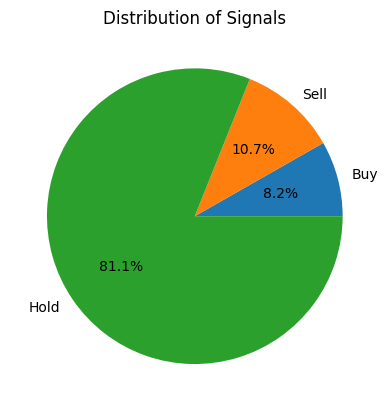

In [89]:
signal_counts = {
    'Buy': buy_signal_counts,
    'Sell': sell_signal_counts,
    'Hold': hold_signal_counts
}

# Create a pie chart
plt.pie(signal_counts.values(), labels=signal_counts.keys(), autopct='%1.1f%%')
plt.title('Distribution of Signals')
plt.show()

In [90]:
stock_df['Signal'] = stock_df['Signal'].map({'Hold': 0, 'Buy': 1, 'Sell': -1})

In [91]:
corr = stock_df.drop(columns =['Date']).corr()

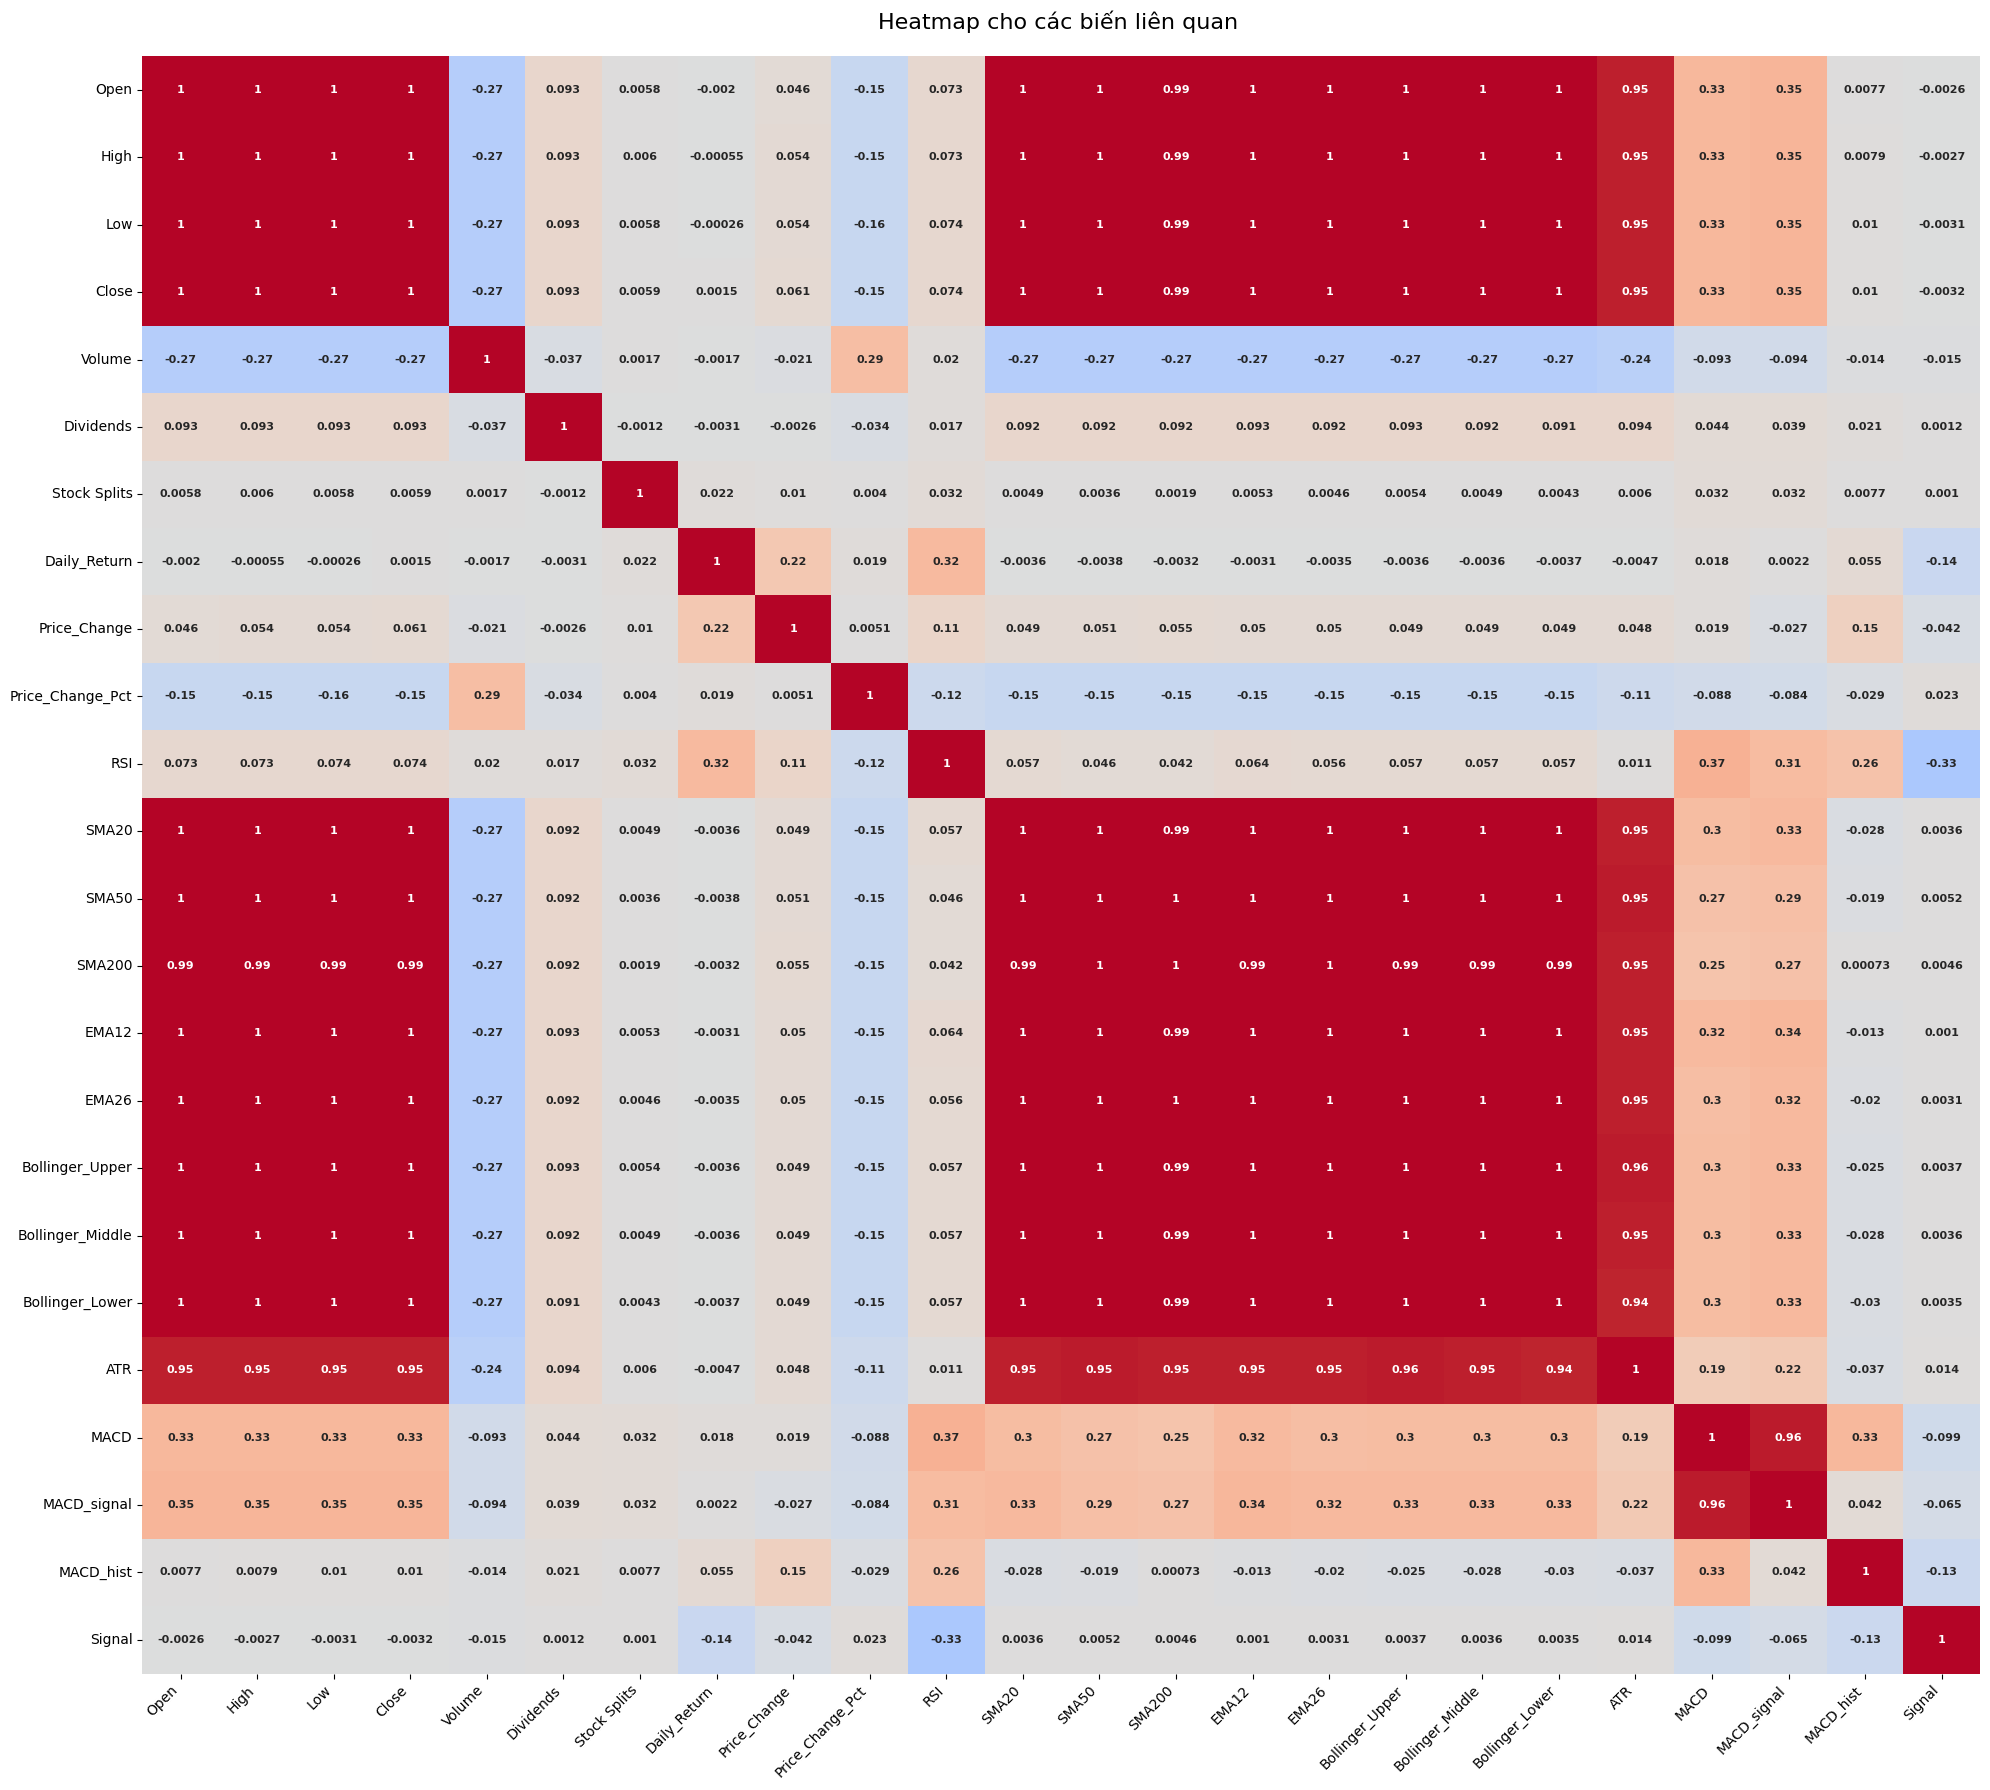

In [92]:
fig, ax = plt.subplots(figsize=(20, 18))  
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True,
            cmap='coolwarm', annot_kws={'fontsize': 8, 'fontweight': 'bold'}, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

plt.title('Heatmap cho các biến liên quan ', fontsize=16, pad=20)
plt.tight_layout()  # Adjust the layout to fit everything
plt.show()

In [93]:
corr_close = corr['Signal']
corr_close = corr_close.abs().sort_values(ascending=False)
print('Correlation :')
print(corr_close)

Correlation :
Signal              1.000000
RSI                 0.328056
Daily_Return        0.143138
MACD_hist           0.129563
MACD                0.099249
MACD_signal         0.064743
Price_Change        0.042039
Price_Change_Pct    0.022561
Volume              0.014638
ATR                 0.014366
SMA50               0.005150
SMA200              0.004593
Bollinger_Upper     0.003701
SMA20               0.003584
Bollinger_Middle    0.003584
Bollinger_Lower     0.003451
Close               0.003246
EMA26               0.003115
Low                 0.003090
High                0.002710
Open                0.002596
Dividends           0.001221
Stock Splits        0.001040
EMA12               0.001006
Name: Signal, dtype: float64


In [94]:
# viết function để tự độngđộng hóa
def correlation(corr, threshold):
    corr_pair = [] # Set of all the names of correlated columns
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold : 
                corr_pair.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))
    return corr_pair
correlated_features = correlation(corr, 0.8) # các features cần bị loại bỏ
drop_features = []
for i ,j, k in correlated_features:
    drop_features.append(j)
drop_features = list(set(drop_features))
drop_features

['SMA200',
 'Open',
 'Bollinger_Middle',
 'Bollinger_Upper',
 'Bollinger_Lower',
 'High',
 'Close',
 'SMA20',
 'SMA50',
 'MACD',
 'EMA26',
 'Low',
 'EMA12']

### ***FEATURE SELECTIONS***

In [95]:
features_to_remove = [
        'SMA20', # Too many moving averages create redundancy, not relevent in choosing signals
        'SMA50', 
        'SMA200',
        'Bollinger_Middle',#remove Bollinger_Middle (the same as SMA20)
        'EMA12'# the same as EMA26 in most cases
    ]
 # Remove correlated features
df_cleaned = stock_df.drop(columns=features_to_remove)
df_cleaned

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Price_Change,Price_Change_Pct,RSI,EMA26,Bollinger_Upper,Bollinger_Lower,ATR,MACD,MACD_signal,MACD_hist,Signal
199,1981-09-28 00:00:00-04:00,0.049472,0.049902,0.049472,0.049472,91728000,0.0,0.0,0.877165,0.000000,0.000000,19.460736,0.064207,0.077869,0.049639,0.002067,-0.005973,-0.004883,-0.001090,1
200,1981-09-29 00:00:00-04:00,0.052053,0.052483,0.052053,0.052053,94684800,0.0,0.0,5.217097,0.000000,0.000000,27.078731,0.063306,0.077645,0.048142,0.002134,-0.006024,-0.005111,-0.000912,0
201,1981-09-30 00:00:00-04:00,0.052483,0.052913,0.052483,0.052483,49996800,0.0,0.0,0.826343,0.000000,0.000000,28.295979,0.062505,0.076402,0.047277,0.002043,-0.005960,-0.005281,-0.000679,0
202,1981-10-01 00:00:00-04:00,0.052483,0.052913,0.052483,0.052483,61129600,0.0,0.0,0.000000,0.000000,0.000000,28.295979,0.061762,0.074531,0.046911,0.001928,-0.005843,-0.005394,-0.000449,0
203,1981-10-02 00:00:00-04:00,0.056785,0.057215,0.056785,0.056785,45046400,0.0,0.0,8.197754,0.000000,0.000000,39.928441,0.061394,0.073078,0.046944,0.002129,-0.005341,-0.005383,0.000042,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11055,2024-10-21 00:00:00-04:00,234.449997,236.850006,234.449997,236.479996,36254500,0.0,0.0,0.629785,2.029999,0.865856,63.419998,228.645067,236.327450,221.838549,4.230731,2.649265,1.902097,0.747168,-1
11056,2024-10-22 00:00:00-04:00,233.889999,236.220001,232.600006,235.860001,38846600,0.0,0.0,-0.262177,1.970001,0.842277,62.123959,229.179506,237.276665,221.738334,4.205679,2.817236,2.085125,0.732111,0
11057,2024-10-23 00:00:00-04:00,234.080002,235.139999,227.759995,230.759995,52287000,0.0,0.0,-2.162302,-3.320007,1.418322,52.601347,229.296580,237.376325,222.077675,4.483845,2.509894,2.170079,0.339815,0
11058,2024-10-24 00:00:00-04:00,229.979996,230.820007,228.410004,230.570007,31109500,0.0,0.0,-0.082331,0.590012,0.256549,52.279856,229.390908,237.468117,222.290882,4.335713,2.225340,2.181131,0.044209,0


### ***BUILD MODEL***

In [96]:
model_df = df_cleaned.copy()

In [97]:
model_df['Signal'].value_counts()

Signal
 0    8805
-1    1160
 1     896
Name: count, dtype: int64

In [98]:
model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df['Date'] = model_df['Date'].apply(lambda x: x.timestamp())

C:\Users\AD\AppData\Local\Temp\ipykernel_16548\1566174337.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  model_df['Date'] = pd.to_datetime(model_df['Date'])


In [99]:
# encode signal
X = model_df.drop(columns = 'Signal').values
y = model_df['Signal'].values

In [100]:
X

array([[ 3.70497600e+08,  4.94716093e-02,  4.99017733e-02, ...,
        -5.97303262e-03, -4.88345454e-03, -1.08957808e-03],
       [ 3.70584000e+08,  5.20525910e-02,  5.24827552e-02, ...,
        -6.02366377e-03, -5.11149639e-03, -9.12167383e-04],
       [ 3.70670400e+08,  5.24827242e-02,  5.29128823e-02, ...,
        -5.96037369e-03, -5.28127185e-03, -6.79101840e-04],
       ...,
       [ 1.72965600e+09,  2.34080002e+02,  2.35139999e+02, ...,
         2.50989387e+00,  2.17007871e+00,  3.39815166e-01],
       [ 1.72974240e+09,  2.29979996e+02,  2.30820007e+02, ...,
         2.22534033e+00,  2.18113103e+00,  4.42092990e-02],
       [ 1.72982880e+09,  2.29740005e+02,  2.33220001e+02, ...,
         2.04404777e+00,  2.15371438e+00, -1.09666607e-01]])

In [101]:
# get relative frequencies
unique_values, counts = np.unique(y, return_counts=True)
relative_frequencies = counts / len(y)

print(relative_frequencies)

[0.10680416 0.81069883 0.08249701]


In [102]:
# Apply SMOTE
smote = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [103]:
# get relative frequencies
unique_values, counts = np.unique(y_resampled, return_counts=True)
relative_frequencies = counts / len(y_resampled)

print(relative_frequencies)

[0.36828645 0.23885641 0.39285714]


In [104]:
#tsr = TimeSeriesResampler(sz=5)
#X_resampled = tsr.fit_transform(X_resampled)
#X_resampled.shape

In [105]:
X_resampled


array([[ 3.77413200e+08,  7.27018416e-02,  7.31320056e-02, ...,
         8.08016823e-04,  1.98160226e-04,  6.09856597e-04],
       [ 3.77758800e+08,  7.57129911e-02,  7.57129911e-02, ...,
         2.23027994e-03,  8.56199552e-04,  1.37408039e-03],
       [ 3.77845200e+08,  7.65732974e-02,  7.70034556e-02, ...,
         2.66783273e-03,  1.21852619e-03,  1.44930654e-03],
       ...,
       [ 1.05391273e+09,  2.61520557e-01,  2.70329417e-01, ...,
         5.24390409e-04, -2.52245573e-07,  5.24642654e-04],
       [ 6.84369459e+08,  3.50060072e-01,  3.50060072e-01, ...,
        -2.86477087e-03,  2.22078536e-03, -5.08555623e-03],
       [ 6.03123796e+08,  2.44559811e-01,  2.47766345e-01, ...,
        -5.28395089e-03, -5.21583318e-03, -6.81177045e-05]])

In [106]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)

In [107]:
#Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],-1))
X_test = scaler.transform(X_test.reshape(X_test.shape[0],-1))

In [108]:
# Train model
forest = RandomForestClassifier(
        class_weight='balanced',
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

In [109]:
accuracy = forest.score(X_test, y_test)
print(f"Accuracy   {accuracy}")
print(f"Classification Report ")
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

Accuracy   0.9105022831050228
Classification Report 
              precision    recall  f1-score   support

          -1       0.92      0.94      0.93       807
           0       0.88      0.80      0.84       523
           1       0.92      0.95      0.94       860

    accuracy                           0.91      2190
   macro avg       0.91      0.90      0.90      2190
weighted avg       0.91      0.91      0.91      2190

[[756  33  18]
 [ 53 417  53]
 [ 15  24 821]]


### ***OPTIMIZATION***

In [110]:
param = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample']
    }

In [111]:
random_search = GridSearchCV(
    estimator=forest,
    param_grid=param,
    scoring= 'f1_weighted',  
    cv=6,
    n_jobs=-1
    )


random_search.fit(X_train, y_train)
pred = random_search.predict(X_test)
best_model = random_search.best_estimator_
best_params_random = random_search.best_params_
print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Model  (Random Search): {best_model}")

Best Parameters (Random Search): {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Model  (Random Search): RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=200, random_state=42)


In [112]:
best_model = RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

In [113]:
accuracy = best_model.score(X_test, y_test)
print(f"Accuracy   {accuracy}")
print(f"Classification Report ")
print(classification_report(y_test, best_pred))

conf_matrix = confusion_matrix(y_test, best_pred)
print(conf_matrix)

Accuracy   0.9136986301369863
Classification Report 
              precision    recall  f1-score   support

          -1       0.92      0.95      0.93       807
           0       0.89      0.80      0.84       523
           1       0.93      0.95      0.94       860

    accuracy                           0.91      2190
   macro avg       0.91      0.90      0.90      2190
weighted avg       0.91      0.91      0.91      2190

[[764  29  14]
 [ 53 419  51]
 [ 17  25 818]]


In [115]:
jb.dump(best_model, 'forestforest.pkl')
jb.dump(scaler, 'scaler_class.pkl')

['scaler_class.pkl']